In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torchvision
from torchvision import transforms
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

In [ ]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(
    weights=torchvision.models.detection.FasterRCNN_ResNet50_FPN_Weights.DEFAULT
)
model.eval()

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 116MB/s]


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

In [ ]:
COLORS = np.random.uniform(0, 255, size=(len(COCO_INSTANCE_CATEGORY_NAMES), 3))
transform = transforms.Compose([
    transforms.ToTensor(),
])

# The torchvision Faster R-CNN models (like fasterrcnn_resnet50_fpn) already include internal preprocessing, which handles:
# Resizing the image to a suitable size (usually with the shorter side resized to 800 pixels, keeping aspect ratio),
# Normalizing using ImageNet mean and std.

In [ ]:
threshold=0.6
path = '/content/drive/My Drive/bicycle.jpg'
img=Image.open(path)
img_tensor = transform(img).unsqueeze(0)
with torch.no_grad():
  raw_pred = model(img_tensor)
pred=raw_pred[0]
print(pred)
scores=pred['scores']
boxes=pred['boxes']
labels=pred['labels']
valid_indices=scores>threshold
pred_boxes=boxes[valid_indices]
pred_scores=scores[valid_indices]
pred_labels=labels[valid_indices]

{'boxes': tensor([[469.7824,  84.9253, 708.7142, 594.0294],
        [363.0780, 275.5305, 812.3452, 612.6479],
        [416.6415, 344.8102, 473.0696, 394.6912],
        [412.1343, 305.2299, 478.7640, 410.9556]]), 'labels': tensor([ 1,  2, 64, 64]), 'scores': tensor([0.9997, 0.9965, 0.0953, 0.0531])}


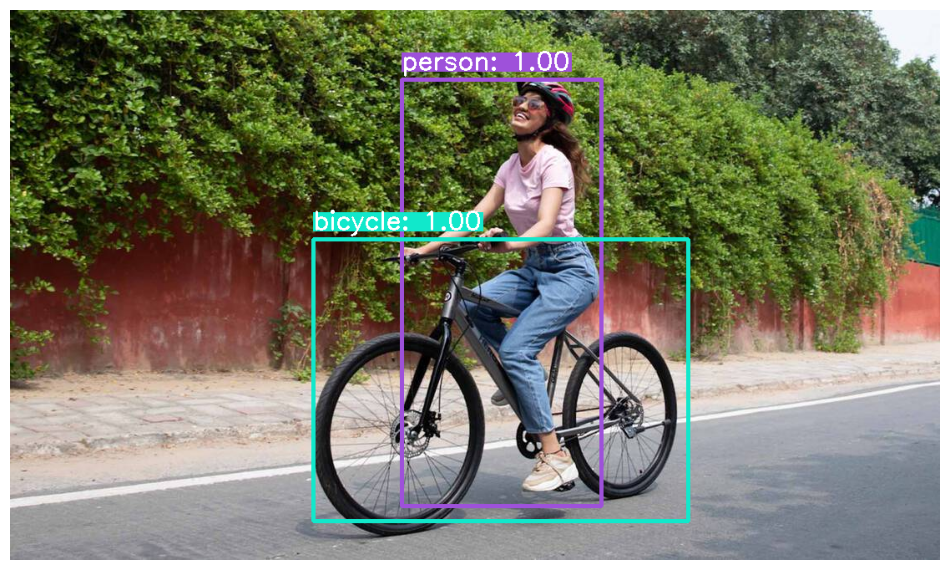

In [ ]:
img = np.array(img)
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
rect_th = max(round(sum(img.shape) / 2 * 0.003), 2)
text_th = max(rect_th - 1, 1)

for i in range(len(pred_boxes)):
    x1, y1, x2, y2 = pred_boxes[i]
    label_id = pred_labels[i]
    label_name = COCO_INSTANCE_CATEGORY_NAMES[label_id]
    color = COLORS[label_id]

    p1 = (int(x1), int(y1))
    p2 = (int(x2), int(y2))
    cv2.rectangle(img, p1, p2, color=color, thickness=rect_th)

    # Draw label background

    label_text = f"{label_name}: {pred_scores[i]:.2f}"
    (w, h), _ = cv2.getTextSize(label_text, cv2.FONT_HERSHEY_SIMPLEX, rect_th / 3, text_th)
    text_bottom = p1[1] - 10 if p1[1] - 10 > 10 else p1[1] + h + 10
    cv2.rectangle(img, (p1[0], text_bottom - h), (p1[0] + w, text_bottom), color, -1)
    cv2.putText(img, label_text, (p1[0], text_bottom - 2), cv2.FONT_HERSHEY_SIMPLEX,
                rect_th / 3, (255, 255, 255), thickness=text_th)

# Convert back to RGB for display

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Display

plt.figure(figsize=(12, 8))
plt.imshow(img)
plt.axis("off")
plt.show()